In [5]:
import numpy as np
import pandas as pd
import gc
import time
import xgboost as xgb
import talib as ta
import os
from random import sample
from os.path import exists
import json
import pickle
from sklearn.model_selection import ParameterGrid,ParameterSampler

In [ ]:
import mysql.connector
import ast
with open('mysql_configure') as f:
    mysqlkeys = f.read()
    mysqlkeys = ast.literal_eval(mysqlkeys)
mydb = mysql.connector.connect(**mysqlkeys,
  database="mycrypto"
)

## 0 Tune settings

In [6]:
PRE_MOD_FOLDER = "./trainedXGB"#'../input/mytrainedxgb' '../input/new-xgbcrypto-tune'
ASSET_DETAILS_CSV = './data/asset_details.csv'

previous_version = sorted([int(s.split('_')[-1]) for s in os.listdir(PRE_MOD_FOLDER) \
                           if 'model_nof' in s])[-1]
params_version=previous_version+1

print(f"Previous version: {previous_version}")
print(f"current saving version: {params_version}")

Previous version: 58
current saving version: 59


In [7]:
#make folder is not exist
os.system(f"mkdir -p {PRE_MOD_FOLDER}/model_nof_{params_version}")
#write necessary notes: check end of the notebook
with open(f'{PRE_MOD_FOLDER}/model_nof_{params_version}/README{params_version}.txt', 'w') as f:
    f.write(f'Version {params_version}\n')

- xgb hyperparameters
  - `params_xgb_prescore`
  - `params_xgb_prebest`
- feature parameters
  - `feature_prescore`
  - `feature_prebest`

In [8]:
tunepara = False #params_xgb
num_pset = 300
tunefeatures=True #feature_params
num_fset = 80
justretrain = False

#################################################################xgb hyperparameters
if exists(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/skipping_pre_next{previous_version}"):
    with open(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/skipping_pre_next{previous_version}",'rb') as fp:
        #if new feature_prebest set to False
        skipping_pre = pickle.load(fp)
else:
    skipping_pre = False

with open(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/params_xgb_best{previous_version}", 'rb') as f: 
    params_xgb_prebest = pickle.load(f)

with open(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/params_xgb_score{previous_version}", "rb") as fp:   
    params_xgb_prescore = pickle.load(fp)
if skipping_pre==False:
    params_xgb_prescore = []


#################################################################feature parameterss
skipping_pre_feature = False #placeholder, depending on the new params_xgb

with open(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/feature_best{previous_version}", "rb") as fp:
    feature_prebest = pickle.load(fp)

with open(PRE_MOD_FOLDER+f"/model_nof_{previous_version}/feature_score{previous_version}", "rb") as fp:   
    feature_prescore = pickle.load(fp)
pre_score = feature_prescore[-1][0]


if justretrain:
    feature_prescore = []
    params_xgb_prescore = []
    
print('tune settings made')

tune settings made


In [9]:
skipping_pre

False

In [10]:
params_xgb_prebest


{'learning_rate': 0.41,
 'max_depth': 5,
 'min_child_weight': 1.1,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'reg_lambda': 2.0,
 'reg_alpha': 1.0}

In [11]:
feature_prebest

{'vol_sum': 15,
 'std_lr_15': 240,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 30,
 'rsi': 40,
 'macd_sig': 15,
 'macd_s': 15,
 'macd_l': 40,
 'lrtn': 30,
 'fastk2': 30,
 'fastk1': 15,
 'beta_s': '6h',
 'beta_l': '2d',
 'adx': 40}

## 1. Load data `new_data.ftr`

In [13]:
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

#######
print("loading new_data4.ftr from folder my-crypto-data")
df_train=pd.read_feather('./data/new_data4.ftr',
                        columns=['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
                               'Volume', 'Target', 'Weight', 'lr_15', 'Mkt_lrt_15','Crypto_Index'])

print('finished loading')
print(df_train.columns)

loading new_data4.ftr from folder my-crypto-data
finished loading
Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Target', 'Weight', 'lr_15', 'Mkt_lrt_15', 'Crypto_Index'],
      dtype='object')


### Split to `df_retrain`, `df_test`

In [14]:
###timestamp endpoints
df_train['timestamp'].quantile(0.45), df_train['timestamp'].quantile(0.95)
pd.to_datetime([df_train['timestamp'].quantile(0.45), 
                df_train['timestamp'].quantile(0.95)],
               unit="s",infer_datetime_format=True)

DatetimeIndex(['2020-01-02 19:42:00', '2021-11-18 14:02:00'], dtype='datetime64[ns]', freq=None)

**make tune/train and test dataset**

In [15]:
df_test = df_train[df_train['timestamp']>=df_train['timestamp'].quantile(0.95)]
df_retrain = df_train[(df_train['timestamp']>df_train['timestamp'].quantile(0.45)) & \
                      (df_train['timestamp']<df_train['timestamp'].quantile(0.95))]

del df_train
gc.collect()

8

## 2. Feature engineering

[TA-LIB doc: https://mrjbq7.github.io/ta-lib/funcs.html](https://mrjbq7.github.io/ta-lib/funcs.html)

In [16]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)

def beta_resid(df, window): 
    num, unit = int(window[:-1]),window[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(width).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(width).mean())).rename(f"beta_{window}")
    b = b.replace([np.nan,np.inf,-np.inf], 0)
    resids = ta.SUB(df.lr_15, ta.MULT(b, df.Mkt_lrt_15)).rename(f"lr_15_resid_{window}")
    return pd.concat([b, resids],axis=1)

def lag_features(df,fastk1,fastk2,adx,macd_s,macd_l,macd_sig,vol_sum,rsi,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15,**kwargs):    
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)#Average Directional Movement Index
    df[f'vol_sum_{vol_sum}'] = ta.SMA(df['Volume'],vol_sum)*vol_sum
    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)
    #####new after mod 49
    #df[f"ATR_{kwargs['ATR']}"] = ta.ATR(df['High'], df['Low'],df['Close'], timeperiod=kwargs['ATR'])
    #df['TRENDLINE'] =ta.HT_TRENDLINE(df['Open'])
    #df[f"willr_{kwargs['willr']}"] = ta.WILLR(df['High'], df['Low'],df['Close'], timeperiod=kwargs['willr'])
    



def get_features(df_feat, fpara_dict):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[[f"beta_{fpara_dict['beta_s']}",f"lr_15_resid_{fpara_dict['beta_s']}"]] = beta_resid(df_feat, window = fpara_dict['beta_s'])
    df_feat[[f"beta_{fpara_dict['beta_l']}",f"lr_15_resid_{fpara_dict['beta_l']}"]] = beta_resid(df_feat, window = fpara_dict['beta_l'])
    df_feat[f"lrtn_index_{fpara_dict['lrtn']}"] = log_return(df_feat.Crypto_Index, fpara_dict['lrtn'])
    lag_features(df_feat, **fpara_dict)
    return df_feat

## 3. hypeparameters and model configure

[xgboost parameters: https://xgboost.readthedocs.io/en/stable/parameter.html](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [17]:
####################################################################################parameters placeholder
#https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters
params_general ={'booster': 'gbtree', 'verbosity':0, 'validate_parameters': 1}

#https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster
params_booster ={
    'learning_rate': 0.3,#check
    'min_split_loss': 0, #gamma. check
    'max_depth': 6,#check
    'min_child_weight': 1, #instance weight (hessian). check
    'subsample': 0.8,#check
    'colsample_bytree': 1,#check
    'reg_lambda': 1,#L2 regularization term on weights
    'reg_alpha': 0, #L1 regularization term on weights
    'max_delta_step': 0,
    'scale_pos_weight': 1,
    'tree_method': 'gpu_hist', #hist
    'predictor': 'gpu_predictor',
    'num_parallel_tree': 1
}
#https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters
params_learning={
    'objective': 'reg:squarederror', 'eval_metric': 'rmse',
    'base_score': 0.5, 'seed': 2021
}

#https://xgboost.readthedocs.io/en/stable/parameter.html#command-line-parameters
params_train={
    'num_boost_round':500, #alias as 'n_estimators' in sklearn api
    'early_stopping_rounds':50, 'verbose_eval':False
}

params_xgb = {**params_general, **params_booster, **params_learning}

print("finish paramx_xgb initialization")

finish paramx_xgb initialization


## 4. Hyperparameters selection(xgb.cv)

- parameters list: [xgboost-parameter](https://xgboost.readthedocs.io/en/stable/parameter.html)
- One asset benchmark(ID=1, Bitcoin)

In [18]:
print(f"skipping params_xgb_pre: {skipping_pre}")

skipping params_xgb_pre: False


In [19]:
##core tuning cv function
def tune_para(search_params, dtrain, skip_pre=False):
    c=0
    for psets in search_params:
        params_xgb.update(psets)
        c+=1
        if skip_pre:
            if psets in [s[2] for s in params_xgb_prescore]:
                print(f'skipping this cv batch {c}/{len(search_params)}')
                continue
        result=xgb.cv(params_xgb, dtrain, 
            num_boost_round=params_train['num_boost_round'], 
            nfold=5,
            metrics=['rmse'], 
            seed=0,verbose_eval=False,as_pandas=True,
            shuffle=False,
            early_stopping_rounds=params_train['early_stopping_rounds'])
        #best score among num_boost_round
        psets_score = (round(result['test-rmse-mean'].min(),7),result.shape[0], psets)
        params_xgb_prescore.append(psets_score)
        print(f"finished {c}/{len(search_params)}")
    return params_xgb_prescore

In [20]:
gridsearch_params = {
    'learning_rate': [i/100 for i in range(30,51,10)],
    'max_depth': [6,10],
    'subsample' : [i/100 for i in range(70,81,10)],
    'colsample_bytree' : [i/100 for i in range(50,81,10)],
    'min_child_weight' : [i/100 for i in range(100,201,10)],
    'reg_lambda' : [i/100 for i in range(100,301,20)] ,
    'reg_alpha' : [i/100 for i in range(40,201,20)]
}
search_params = list(ParameterSampler(param_distributions = gridsearch_params, n_iter = num_pset))
#search_params = list(ParameterGrid(param_grid = gridsearch_params))
if params_xgb_prebest in search_params:
    pass
else:
    search_params.append(params_xgb_prebest)

In [18]:
#make tune data
df = df_retrain[df_retrain["Asset_ID"] == 1]
pd.options.mode.chained_assignment = None  # default='warn'
df = get_features(df, feature_prebest)
df.dropna(axis = 0, inplace= True)#for lag_features missing rows:<100
dtrain=xgb.DMatrix(df.drop(['timestamp', 'Asset_ID','Target','Weight'],axis=1),label= df['Target'])

del df
gc.collect()

37

In [19]:
##############################start tuning and update params_xgb, logging ,setup skipping_pre_feature
if tunepara:
    print('Start tuning')
    params_xgb_score=tune_para(search_params,dtrain,skip_pre = skipping_pre)
    del dtrain
    gc.collect()
    ##score ranking rules min: rmse,min_child_weight,learning_rate,reg_alpha
    params_xgb_score.sort(key=lambda x: (x[0],x[2]['min_child_weight'],x[2]['learning_rate'],x[2]['reg_alpha']))
    params_xgb.update(params_xgb_score[0][2])
    
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/params_xgb_score{params_version}", "wb") as fp:   
        pickle.dump(params_xgb_score, fp)
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/params_xgb_best{params_version}", 'wb') as f: 
        pickle.dump(params_xgb_score[0][2],f)
    if params_xgb_score[0][2] == params_xgb_prebest:
        print('best params_xgb does not change!')
        skipping_pre_feature = True
    else:
        print('best params_xgb differs!')
        skipping_pre_feature = False
        feature_prescore = []
else:
    params_xgb.update(params_xgb_prebest)
    
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/params_xgb_score{params_version}", "wb") as fp:   
        pickle.dump(params_xgb_prescore, fp)
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/params_xgb_best{params_version}", 'wb') as f: 
        pickle.dump(params_xgb_prebest,f)
    skipping_pre_feature = True

In [20]:
params_xgb

{'booster': 'gbtree',
 'verbosity': 0,
 'validate_parameters': 1,
 'learning_rate': 0.41,
 'min_split_loss': 0,
 'max_depth': 5,
 'min_child_weight': 1.1,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'reg_lambda': 2.0,
 'reg_alpha': 1.0,
 'max_delta_step': 0,
 'scale_pos_weight': 1,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor',
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'base_score': 0.5,
 'seed': 2021}

## 5. Feature Selection

In [21]:
print(f"skipping feature_pre: {skipping_pre_feature}")

skipping feature_pre: True


In [22]:
def train_model_for_asset(df_train,asset_id, fpara_dict):
    pd.options.mode.chained_assignment = None
    dftrain = df_train[df_train["Asset_ID"] == asset_id].copy()
    dftrain = get_features(df_feat=dftrain, fpara_dict=fpara_dict)
    dftrain.dropna(axis = 0, inplace= True)
    dmat_train=xgb.DMatrix(data = dftrain.drop(['timestamp', 'Asset_ID','Target','Weight'],
                                        axis=1),
                    label= dftrain['Target'])
    del dftrain
    gc.collect()
    model = xgb.train(params_xgb, dtrain=dmat_train, 
                    evals=[(dmat_train,'train')],
                    **params_train)
    return model

def model_reload_train(df_train, fpara_dict):
    models={}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        models[asset_id] = train_model_for_asset(df_train,asset_id, fpara_dict)
    return models

def make_testset(df, fpara_dict):
    ###consistent timestamp for all 14 assets
    df2 = df.copy()
    ###add features
    df2 = df2.groupby('Asset_ID').apply(lambda x: get_features(x, fpara_dict))
    return df2.dropna(axis = 0)#.reset_index()

def weighted_correlation(a, b, weights):
  w = np.ravel(weights)
  a = np.ravel(a)
  b = np.ravel(b)
  sum_w = np.sum(w)
  mean_a = np.sum(a * w) / sum_w
  mean_b = np.sum(b * w) / sum_w
  var_a = np.sum(w * np.square(a - mean_a)) / sum_w
  var_b = np.sum(w * np.square(b - mean_b)) / sum_w

  cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
  corr = cov / np.sqrt(var_a * var_b)
  return corr

In [23]:
feature_prebest

{'std_lr_15': 30,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 30,
 'rsi': 30,
 'adx': 50,
 'macd_sig': 15,
 'macd_s': 10,
 'macd_l': 60,
 'lrtn': 50,
 'fastk2': 10,
 'fastk1': 15,
 'beta_s': '6h',
 'beta_l': '2d',
 'vol_sum': 15}

In [21]:
param_grid = {
'std_lr_15': [30,40,60,120,240],
 'std_Mkt_lrt_15': [10,15,30,50,60,120,240],
 'std_Crypto_Index': [30,40,60,120,240],
 'macd_sig': [15,20],
 'macd_s': [10,15,30],
 'macd_l': [60,40],
 'lrtn': [50,30,15],
 'fastk2': [10,30,50],
 'fastk1': [15,20,40],
 'beta_s': ['6h','12h'],
 'beta_l': ['2d'],
 'vol_sum': [15,30],
 'adx': [40,50,60],
 'rsi':[30,40,50,60]
}

p_grid = list(ParameterSampler(param_distributions = param_grid, n_iter = num_fset))
#p_grid = list(ParameterGrid(param_grid = param_grid))
if feature_prebest in p_grid:
    pass
else:
    p_grid.append(feature_prebest)

len(p_grid)

81

In [25]:
if tunefeatures:
    c = 0
    for psets in p_grid:
        c += 1
        if skipping_pre_feature:
            if psets in [s[1] for s in feature_prescore]:
                print(f"skipping scoring for feature parameters set{c} /{len(p_grid)}")
                continue
        #############################################train model
        models = model_reload_train(df_train=df_retrain, fpara_dict = psets)
        #############################################score model with the features' params
        print(f"scoring for feature parameters set{c} /{len(p_grid)}")
        df_test2 = make_testset(df = df_test, fpara_dict = psets)
        result_frame = []
        for id in range(0,14):
            model = models[id]
            x = df_test2[df_test2['Asset_ID']==id]
            x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
            result_frame.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
        result = pd.concat(result_frame, axis=0)
        score = weighted_correlation(a=result['Target'],b=result['Pred'],weights=result['Weight'])
        feature_prescore.append((score,psets))##add to feature_score logs
    ##########################
    feature_prescore.sort(key=lambda y: y[0])
    final_score, final_fpara_dict = feature_prescore[-1]
else:
    print("make score for new params_xgb")
    models = model_reload_train(df_train=df_retrain, fpara_dict = feature_prebest)
    df_test2 = make_testset(df = df_test, fpara_dict = feature_prebest)
    result_frame = []
    for id in range(0,14):
        model = models[id]
        x = df_test2[df_test2['Asset_ID']==id]
        x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
        result_frame.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
    result = pd.concat(result_frame, axis=0)
    score = weighted_correlation(a=result['Target'],b=result['Pred'],weights=result['Weight'])
    feature_prescore.append((score, feature_prebest))
    final_score, final_fpara_dict = score, feature_prebest
    
###logging feature tune
with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/feature_score{params_version}", "wb") as fp:   
    pickle.dump(feature_prescore, fp)
with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/feature_best{params_version}", "wb") as fp:   
    pickle.dump(final_fpara_dict, fp)

scoring for feature parameters set1 /81
scoring for feature parameters set2 /81
scoring for feature parameters set3 /81
scoring for feature parameters set4 /81
scoring for feature parameters set5 /81
scoring for feature parameters set6 /81
scoring for feature parameters set7 /81
scoring for feature parameters set8 /81
scoring for feature parameters set9 /81
scoring for feature parameters set10 /81
scoring for feature parameters set11 /81
scoring for feature parameters set12 /81
scoring for feature parameters set13 /81
scoring for feature parameters set14 /81
scoring for feature parameters set15 /81
scoring for feature parameters set16 /81
scoring for feature parameters set17 /81
scoring for feature parameters set18 /81
scoring for feature parameters set19 /81
scoring for feature parameters set20 /81
scoring for feature parameters set21 /81
scoring for feature parameters set22 /81
scoring for feature parameters set23 /81
scoring for feature parameters set24 /81
scoring for feature param

In [26]:
with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/skipping_pre_next{params_version}", "wb") as fp:   
    if final_fpara_dict == feature_prebest:
        #no change to the feature params, we can skip scored params_xgb next time
        print('best feature params does not change!')
        pickle.dump(True, fp)
    else:
        print('best feature params differs!')
        pickle.dump(False, fp)

best feature params differs!


## 6. Train models with optimal hyperparameters and features

In [27]:
final_score, final_fpara_dict, pre_score

(0.03993893506100587,
 {'vol_sum': 15,
  'std_lr_15': 240,
  'std_Mkt_lrt_15': 10,
  'std_Crypto_Index': 30,
  'rsi': 40,
  'macd_sig': 15,
  'macd_s': 15,
  'macd_l': 40,
  'lrtn': 30,
  'fastk2': 30,
  'fastk1': 15,
  'beta_s': '6h',
  'beta_l': '2d',
  'adx': 40},
 0.03678390028166218)

{"learner":{"generic_param":{"fail_on_invalid_gpu_id":"0","gpu_id":"0","n_jobs":"2","nthread":"2","random_state":"2021","seed":"2021","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_train_param":{"num_parallel_tree":"1","predictor":"gpu_predictor","process_type":"default","tree_method":"gpu_hist","updater":"grow_gpu_hist","updater_seq":"grow_gpu_hist"},"name":"gbtree","specified_updater":false,"updater":{"grow_gpu_hist":{"gpu_hist_train_param":{"debug_synchronize":"0","single_precision_histogram":"0"},"train_param":{"alpha":"1","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"0.600000024","default_direction":"learn","eta":"0.409999996","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"2","learning_rate":"0.409999996","max_bin":"256","max_conflict_rate":"0","max_delta_step":"0","max_depth":"5","max_leaves":"0","max_search_group":"100","min_child_weight":"1.10000002","min_split_loss":"0","monoton

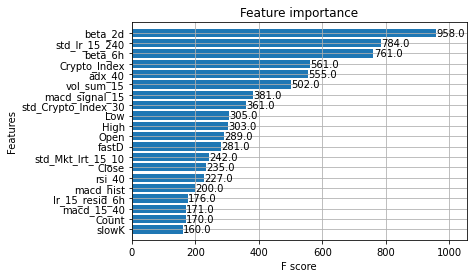

In [28]:
def model_retrain(df_train, fpara_dict, alldata):
    models={}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        
        models[asset_id] = train_model_for_asset(df_train, asset_id, fpara_dict)
        if alldata:
            print(f"df_retrain model fitting for asset_id {asset_id}",end='\r')
            models[asset_id].save_model(f'./model_nof_{params_version}/model_{asset_id}_alldata.json')
        else:
            print(f"all data model fitting for asset_id {asset_id}", end = '\r')
            models[asset_id].save_model(f'./model_nof_{params_version}/model_{asset_id}.json')
    return models

if final_score < pre_score:
    print('No improvement, No train!')
else:    
    models = model_retrain(df_train= df_retrain, 
                           fpara_dict= final_fpara_dict,alldata=False)
    models_alldata = model_retrain(df_train= pd.concat([df_retrain,df_test], join='outer'), 
                                   fpara_dict= final_fpara_dict,alldata=True)
    print(models[0].save_config())
    print(models[0].feature_names)
    xgb.plot_importance(models[1],height=0.8, max_num_features=20)

In [29]:
#write readable notes
with open(f'{PRE_MOD_FOLDER}/model_nof_{params_version}/README{params_version}.txt', 'a') as f:
    notes = f"""
    Use feature para selection: {tunefeatures}
    Features params: {final_fpara_dict}
    Use auto-tuned hyperpara: {tunepara}
    Xgb-hyperparams: {params_xgb}
    On-test-score: {final_score}
    """
    f.write(f'{notes}\n')
# if tunepara <1:
#     import shutil
#     shutil.make_archive(f'./model_nof_{params_version}', 'zip', f'./model_nof_{params_version}')

In [30]:
if final_score > pre_score:
    print("Improved!!!")
    print(f"{final_score} greater than {pre_score}")
else:
    print(f"Not improved!!!")
    ##recover prebest params
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/params_xgb_best{params_version}", 'wb') as f: 
        pickle.dump(params_xgb_prebest,f)
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/feature_best{params_version}", "wb") as fp:   
        pickle.dump(feature_prebest, fp)
    with open(f"{PRE_MOD_FOLDER}/model_nof_{params_version}/skipping_pre_next{params_version}", "wb") as fp:   
        pickle.dump(True, fp)

Improved!!!
0.03993893506100587 greater than 0.03678390028166218
